# Parte 1: Detecção de faces

Bibliotecas utilizadas.

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
import itertools
import pandas as pd

Carregamento e conversão da imagem trabalhada.
A imagem carregada BGR é convertida para o padrão RGB.
Imagem RGB é convertida para escala de cinzas.

In [18]:
img = cv2.cvtColor(cv2.imread('data/cenario01.png'), cv2.COLOR_BGR2RGB)
img_temp = img.copy()

gray = cv2.cvtColor(img_temp, cv2.COLOR_RGB2GRAY)

Exibição das imagens original e em escala de cinzas.

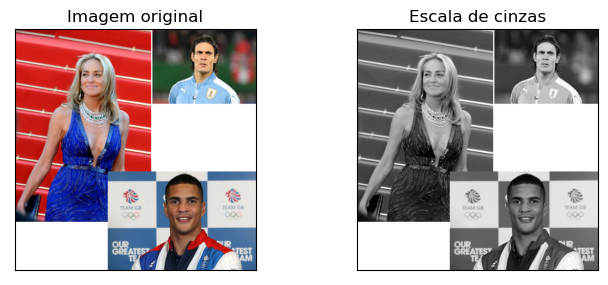

In [19]:
fig_luz, axes = plt.subplots(1,2,figsize=(7,3), dpi = 100)
plt.tight_layout()

for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
axes[0].imshow(img_temp)
axes[0].set_title('Imagem original')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title('Escala de cinzas')

plt.show()

Carregamento do arquivo .XML pré-treinado com as características haar para detecção de faces frontais.

In [20]:
face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

Detecção das faces na imagem em escala de cinzas. O valor do fator de escala utilizado é 1,1 e o número mínimo de vizinhos é 4. É retornado os bounding boxes das possíveis faces detectadas.

In [21]:
box = face_cascade.detectMultiScale(gray, scaleFactor = 1.1, minNeighbors = 4)

Desenho dos retângulos das faces detectadas. Além disso, é obtido os pontos centrais das bounding boxes para posterior calculo da distâncias entre as faces detectadas.

In [22]:
cxy = np.zeros((box.shape[0], 2))

i = 0
for (x, y, w, h) in box:
    
    cx, cy = int(x+w/2), int(y+h/2)
    
    cxy[i,:] = (cx, cy)
    i+=1
    
    cv2.rectangle(img_temp, (x, y), (x+w, y+h), (0, 255, 0), 5)

Exibição da imagem trabalhada com os bounding boxes das faces detectadas.

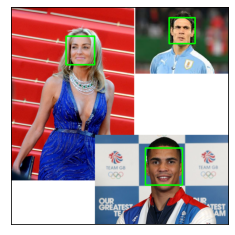

In [23]:
plt.imshow(img_temp)
plt.xticks([]), plt.yticks([])
plt.show()

# Parte 2: Classificação de faces

Extração e preperação das imagens das faces detectadas para a classificação.

In [24]:
net_size = (224, 224)

faces = np.zeros((box.shape[0], net_size[0], net_size[0],
                  img.shape[2]), dtype=np.uint8)

for i in range(box.shape[0]):
    x, y, w, h = box[i]
    face = img[y:y+h, x:x+w]
    face = cv2.resize(face, net_size, interpolation = cv2.INTER_AREA)
    faces[i,:,:,:] = face

In [25]:
print(faces.shape)
print(faces.dtype)

(3, 224, 224, 3)
uint8


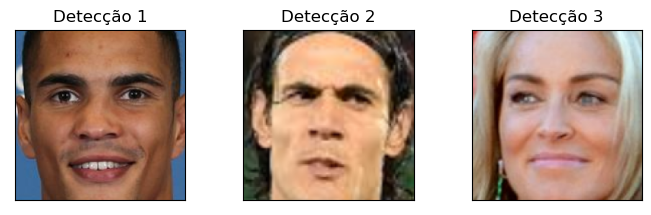

In [36]:
fig_luz, axes = plt.subplots(1,3,figsize=(7,3), dpi = 100)
plt.tight_layout()

for ax in axes:
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
axes[0].imshow(faces[0])
axes[0].set_title('Detecção 1')

axes[1].imshow(faces[1], cmap='gray')
axes[1].set_title('Detecção 2')

axes[2].imshow(faces[2], cmap='gray')
axes[2].set_title('Detecção 3')

plt.show()

In [27]:
samples = faces.astype('float32')

print(samples.min(), samples.max())

0.0 255.0


In [28]:
samples = preprocess_input(samples, version=2)

print(samples.min(), samples.max())

-131.0912 163.5047


Carregamento do modelo pré-treinado, predição e decodificação dos resultados de classificação.

In [32]:
model = VGGFace(model='resnet50')

model.summary()

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_3[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

In [33]:
yhat = model.predict(samples)

print(yhat.shape)

(3, 8631)


In [35]:
results = decode_predictions(yhat, top=5)

for i in range(np.size(results, axis=0)):
    print('\nDetecção', i+1)
    for result in results[i]:
        print('%s: %.3f%%' % (result[0], result[1]*100))


Detecção 1
b' Anthony_Ogogo': 99.913%
b' Brahim_Asloum': 0.007%
b' Scott_Quigg': 0.006%
b' Anthony_Mundine': 0.005%
b' Brian_Viloria': 0.005%

Detecção 2
b' Edinson_Cavani': 98.043%
b' Juliano_Cazarre': 0.075%
b' Tino_Costa': 0.075%
b' Rio_Ferdinand': 0.047%
b' Salvatore_Sirigu': 0.043%

Detecção 3
b' Sharon_Stone': 97.929%
b' Noelle_Reno': 0.985%
b' Tina_Maze': 0.092%
b' Anita_Lipnicka': 0.060%
b' Elisabeth_R\xc3\xb6hm': 0.050%


# Parte 3: Análise dos resultados

Combinações das faces de pessoas detectadas.

In [40]:
A = results[0][0][0][3:-1]
B = results[1][0][0][3:-1]
C = results[2][0][0][3:-1]

c = list(itertools.combinations([A, B, C], 2))

In [41]:
points = list(itertools.combinations([cxy[0], cxy[1], cxy[2]], 2))

Distância euclidiana entre o centro das faces detectadas.

In [42]:
psize = np.size(points, axis=0)

distance = np.zeros((psize))
for i in range(psize):
    distance[i] = np.linalg.norm(points[i][1]-points[i][0])

Dicionário com as combinações e distância entre as faces detectadas.

In [43]:
myDict = {'Combinações':c,
          'Distância': distance}

In [44]:
resultDF = pd.DataFrame(myDict)
resultDF.head()

,Combinações,Distância
0,"(Anthony_Ogogo, Edinson_Cavani)",629.495830
1,"(Anthony_Ogogo, Sharon_Stone)",656.920848
2,"(Edinson_Cavani, Sharon_Stone)",475.783564


In [45]:
threshold = 500

contactDF = resultDF.loc[resultDF['Distância'] < 500]
contactDF.head()

,Combinações,Distância
2,"(Edinson_Cavani, Sharon_Stone)",475.783564
